# Comparison of Full vs Profile Likelihood Methods



### How to run the code

#### On local machine

Run `/benchmark/scripts/benchmark_speed.py`.

The output is stored in `/benchnmark/pickle_results/benchmark_results.pickle`. 


#### Run on cluster

To run this script on a cluster with Torque:

    cd jobfiles
    qsub jobfile_benchmark_speed.pbs

In [1]:
import numpy
import pickle
import pprint
pp = pprint.PrettyPrinter(indent=4)

from os.path import join
import matplotlib
import matplotlib.ticker
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator
import seaborn as sns
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
#matplotlib.font_manager._rebuild() 
sns.set(font_scale=1.2)
sns.set_style("white")
sns.set_style("ticks")
plt.rc('font', family='serif')
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
benchmark_dir = '..'
# base_filename = 'benchmark_speed_dense'
base_filename = 'benchmark_speed'
#base_filename = 'benchmark_speed_sparse_cg'
#base_filename = 'benchmark_speed_sparse_ncg'
results_filename = join(benchmark_dir, 'pickle_results', base_filename + '.pickle')

with open(results_filename, 'rb') as file:
    benchmark_result = pickle.load(file)
    
print('Config:')
pp.pprint(benchmark_result['config'])
print('')
print('Devices:')
pp.pprint(benchmark_result['devices'])
print('')
results = benchmark_result['results']
num_data = len(results)
print('num data: %d' % num_data)
print('')
date = benchmark_result['date']
print('date: %s' % date)

# Extract variables
data_sizes = benchmark_result['config']['data_sizes']
repeat = benchmark_result['config']['repeat']

# ====
# read
# ====

def read(var_name, key):
    """
    Reads variable ``var`` from the dictionary and creates numpy array.
    """
    
    var = {}
    var['full'] = numpy.zeros((num_data, repeat), dtype=float)
    var['prof'] = numpy.zeros((num_data, repeat), dtype=float)
    
    for i in range(num_data):
        for j in range(repeat):
            
            if key in results[i]['full_likelihood'][j]:
                if var_name in results[i]['full_likelihood'][j][key]:
                    var['full'][i, j] = results[i]['full_likelihood'][j][key][var_name]
                    
            if key in results[i]['prof_likelihood'][j]:
                if var_name in results[i]['prof_likelihood'][j][key]:
                    var['prof'][i, j] = results[i]['prof_likelihood'][j][key][var_name]
    
    return var
                 
# ------------
                 
opt_proc_time = read('opt_proc_time', 'time')
opt_wall_time = read('opt_wall_time', 'time')
cor_proc_time = read('cor_proc_time', 'time')
cor_wall_time = read('cor_wall_time', 'time')
det_proc_time = read('det_proc_time', 'time')
det_wall_time = read('det_wall_time', 'time')
trc_proc_time = read('trc_proc_time', 'time')
trc_wall_time = read('trc_wall_time', 'time')
sol_proc_time = read('sol_proc_time', 'time')
sol_wall_time = read('sol_wall_time', 'time')
lik_proc_time = read('lik_proc_time', 'time')
lik_wall_time = read('lik_wall_time', 'time')
cor_count = read('cor_count', 'time')
det_count = read('det_count', 'time')
trc_count = read('trc_count', 'time')
sol_count = read('sol_count', 'time')
lik_count = read('lik_count', 'time')
sigma = read('sigma', 'hyperparam')
eq_sigma = read('eq_sigma', 'hyperparam')
sigma0 = read('sigma0', 'hyperparam')
eta = read('eta', 'hyperparam')
density = read('density', 'data')
nnz = read('nnz', 'data')
avg_row_nnz = read('avg_row_nnz', 'data')
num_opt_iter = read('num_opt_iter', 'optimization')
num_fun_eval = read('num_fun_eval', 'optimization')
num_jac_eval = read('num_jac_eval', 'optimization')
num_hes_eval = read('num_hes_eval', 'optimization')
success = read('success', 'optimization')

max_fun = {}
max_fun['full'] = numpy.zeros((num_data, repeat), dtype=float)
max_fun['prof'] = numpy.zeros((num_data, repeat), dtype=float)
max_fun_rel = numpy.zeros((num_data, repeat), dtype=float)

sizes = numpy.zeros((num_data, ), dtype=float)
for i in range(num_data):
    sizes[i] = results[i]['full_likelihood'][0]['data']['size']
    
    #  Repeats of experiments
    for j in range(repeat):

        max_fun['full'][i] = results[i]['full_likelihood'][j]['optimization']['max_fun']

        max_fun_prof = results[i]['prof_likelihood'][j]['optimization']['max_fun']
        if isinstance(max_fun_prof, float):
            max_fun['prof'][i, j] = max_fun_prof
            max_fun_rel[i, j] = 1.0 - max_fun['prof'][i, j] / max_fun['full'][i, j]
        else:
            max_fun['prof'][i, j] = numpy.nan
            max_fun_rel[i, j] = numpy.nan

Config:
{   'B': None,
    'b': None,
    'data_sizes': array([ 64,  71,  80,  90, 101, 114, 128]),
    'dimension': 2,
    'grid': True,
    'hyperbolic_coeff': None,
    'hyperparam_guesses': {'none': None, 'var': None},
    'imate_options': {   'none': {   'lanczos_degree': 50,
                                     'max_num_samples': 100,
                                     'method': 'slq',
                                     'min_num_samples': 50},
                         'var': {   'lanczos_degree': 50,
                                    'max_num_samples': 100,
                                    'method': 'slq',
                                    'min_num_samples': 50}},
    'kernel': 'Exponential',
    'kernel_threshold': 0.02,
    'noise_magnitude': 0.2,
    'optimization_method': {'none': 'BFGS', 'var': 'BFGS'},
    'polynomial_degree': 2,
    'profile_hyperparam': ['none', 'var'],
    'repeat': 2,
    'scale': 0.005,
    'sparse': True,
    'tol': 0.0001,
    'trigonometr

In [3]:
def log_fit(x, y):
    """
    finds a in y = x**a
    """
    
    log2_x = numpy.log2(x)
    log2_y = numpy.log2(y)
    
    coeff = numpy.polyfit(log2_x, log2_y, 1)
    slope = coeff[0]
    
    # Interpolation
    log2_xi = numpy.linspace(log2_x[0], log2_x[-1])
    log2_yi = numpy.polyval(coeff, log2_xi)
    
    xi = 2**(log2_xi)
    yi = 2**(log2_yi)
    
    return slope, xi, yi

In [4]:
# Plot Variables
plot_wall_time = False
full_color = '#0093FF'
prof_color = '#77B900'

# ========
# plot var
# ========

def plot_var(ax_, var, ylabel, title, ylog=False, error=True, fit=False):

    if isinstance(var, dict):
        # Plots both full likelihood and profiled likelihood
        var_full_mean = numpy.mean(var['full'], axis=1)
        var_prof_mean = numpy.mean(var['prof'], axis=1)
        
        if error:
            # Plots with errorbar
            var_full_std = numpy.std(var['full'], axis=1)
            var_prof_std = numpy.std(var['prof'], axis=1)
            zeros = numpy.zeros_like(var_full_std)
            
        else:
            # Plots without errorbar
            var_full_std = None
            var_prof_std = None
            zeros = None
            
        full_label = 'full'
        prof_label = 'prof'
        
        if fit:
            # Plots linear fit
            slope_full, xi_full, yi_full = log_fit(sizes, var_full_mean)
            slope_prof, xi_prof, yi_prof = log_fit(sizes, var_prof_mean)
            
            full_label += ', slope: %0.2f' % slope_full
            prof_label += ', slope: %0.2f' % slope_prof
            
            ax_.plot(xi_full, yi_full, '--', color=full_color)
            ax_.plot(xi_prof, yi_prof, '--', color=prof_color)
        
        ax_.errorbar(sizes, var_full_mean, yerr=[zeros, var_full_std], fmt='-o', color=full_color,
                     label=full_label)
        ax_.errorbar(sizes, var_prof_mean, yerr=[zeros, var_prof_std], fmt='-s', color=prof_color,
                     label=prof_label)
        
        handles,labels = ax_.get_legend_handles_labels()
        ax_.legend(handles, labels, fontsize='x-small')
        
    else:
        # Plots only one variable
        var_mean = numpy.mean(var, axis=1)
        
        if error:
            var_std = numpy.std(var, axis=1)
        else:
            var_std = None
            
        ax_.errorbar(sizes, var_mean, yerr=var_std, fmt='-o', color=full_color)
        
        if fit:
            # Plots linear fit
            slope, xi, yi = log_fit(sizes, var_mean)
            ax_.plot(xi, yi, '--', color=full_color, label='slope: %0.2f' % slope)
            
            handles,labels = ax_.get_legend_handles_labels()
            ax_.legend(handles, labels, fontsize='x-small')

    ax_.set_xscale('log', base=2)
    if ylog:
        ax_.set_yscale('log', base=10)

    ax_.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax_.get_xaxis().get_major_formatter().labelOnlyBase = False
    
    log2_sizes = numpy.log2(sizes)
    log2_sizes_int = numpy.arange(int(log2_sizes[0]), int(log2_sizes[-1]+0.5)+1e-8)
    sizes_int = 2**log2_sizes_int
    ax_.set_xticks(sizes_int)

    ax_.set_ylabel(ylabel)
    ax_.set_title(title)

    ax_.set_xlabel(r'$n$')
    ax_.grid(axis='y', which='major')
    
# =========
# save plot
# =========

def save_plot(plt, name):
    
    plt.tight_layout()
    save_dir = 'svg_plots'
    filename_svg = name + '.svg'
    plt.savefig(join(benchmark_dir, save_dir, filename_svg), transparent=True, bbox_inches='tight')
    print('Plot saved to "%s".' % (filename_svg))

Plot saved to "benchmark_speed_proc_time.svg".


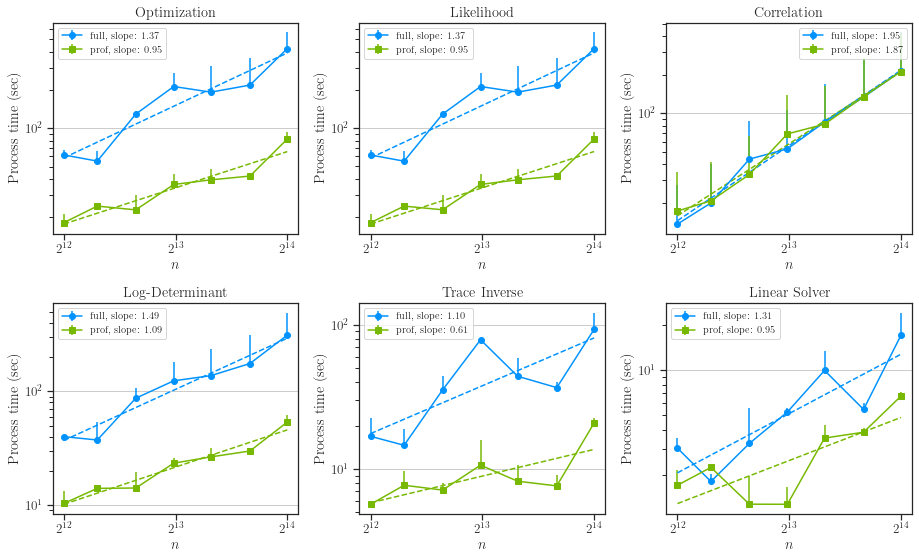

In [5]:
fig, ax = plt.subplots(figsize=(13, 8), nrows=2, ncols=3)

# Plot time
plot_var(ax[0, 0], opt_proc_time, 'Process time (sec)', 'Optimization', ylog=True, fit=True)
plot_var(ax[0, 1], lik_proc_time, 'Process time (sec)', 'Likelihood', ylog=True, fit=True)
plot_var(ax[0, 2], cor_proc_time, 'Process time (sec)', 'Correlation', ylog=True, fit=True)
plot_var(ax[1, 0], det_proc_time, 'Process time (sec)', 'Log-Determinant', ylog=True, fit=True)
plot_var(ax[1, 1], trc_proc_time, 'Process time (sec)', 'Trace Inverse', ylog=True, fit=True)
plot_var(ax[1, 2], sol_proc_time, 'Process time (sec)', 'Linear Solver', ylog=True, fit=True)

# Save plot
save_plot(plt, 'benchmark_speed_proc_time')

Plot saved to "benchmark_speed_wall_time.svg".


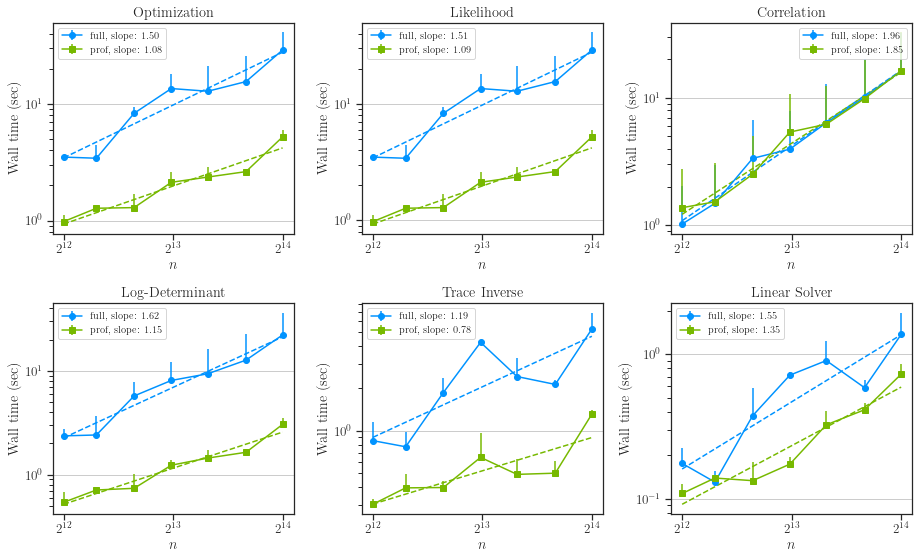

In [6]:
fig, ax = plt.subplots(figsize=(13, 8), nrows=2, ncols=3)

# Plot time
plot_var(ax[0, 0], opt_wall_time, 'Wall time (sec)', 'Optimization', ylog=True, fit=True)
plot_var(ax[0, 1], lik_wall_time, 'Wall time (sec)', 'Likelihood', ylog=True, fit=True)
plot_var(ax[0, 2], cor_wall_time, 'Wall time (sec)', 'Correlation', ylog=True, fit=True)
plot_var(ax[1, 0], det_wall_time, 'Wall time (sec)', 'Log-Determinant', ylog=True, fit=True)
plot_var(ax[1, 1], trc_wall_time, 'Wall time (sec)', 'Trace Inverse', ylog=True, fit=True)
plot_var(ax[1, 2], sol_wall_time, 'Wall time (sec)', 'Linear Solver', ylog=True, fit=True)

# Save plot
save_plot(plt, 'benchmark_speed_wall_time')

Plot saved to "benchmark_speed_task_counter.svg".


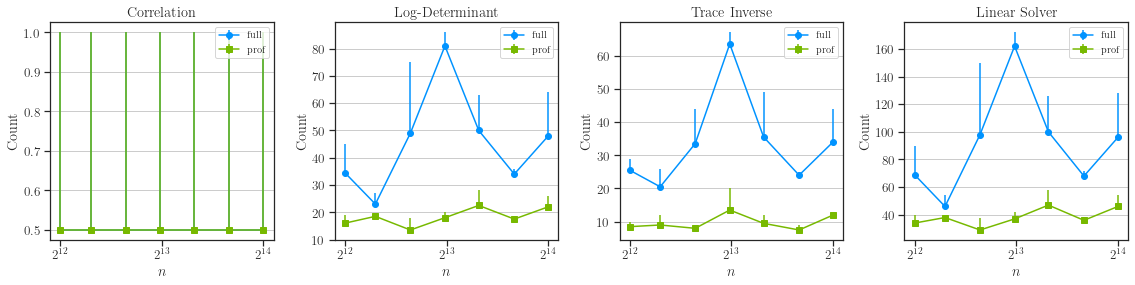

In [7]:
fig, ax = plt.subplots(figsize=(16, 4.2), nrows=1, ncols=4)

# Plot iterations
plot_var(ax[0], cor_count, 'Count', 'Correlation')
plot_var(ax[1], det_count, 'Count', 'Log-Determinant')
plot_var(ax[2], trc_count, 'Count', 'Trace Inverse')
plot_var(ax[3], sol_count, 'Count', 'Linear Solver')

# Save plot
save_plot(plt, 'benchmark_speed_task_counter')

Plot saved to "benchmark_speed_iter.svg".


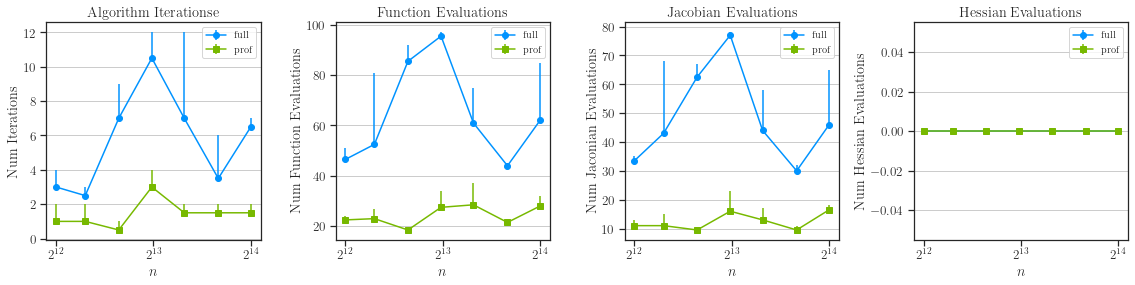

In [8]:
fig, ax = plt.subplots(figsize=(16, 4.2), nrows=1, ncols=4)

# Plot iterations
plot_var(ax[0], num_opt_iter, 'Num Iterations', 'Algorithm Iterationse')
plot_var(ax[1], num_fun_eval, 'Num Function Evaluations', 'Function Evaluations')
plot_var(ax[2], num_jac_eval, 'Num Jaconian Evaluations', 'Jacobian Evaluations')
plot_var(ax[3], num_hes_eval, 'Num Hessian Evaluations', 'Hessian Evaluations')

# Save plot
save_plot(plt, 'benchmark_speed_iter')

Plot saved to "benchmark_speed_hyperparam.svg".


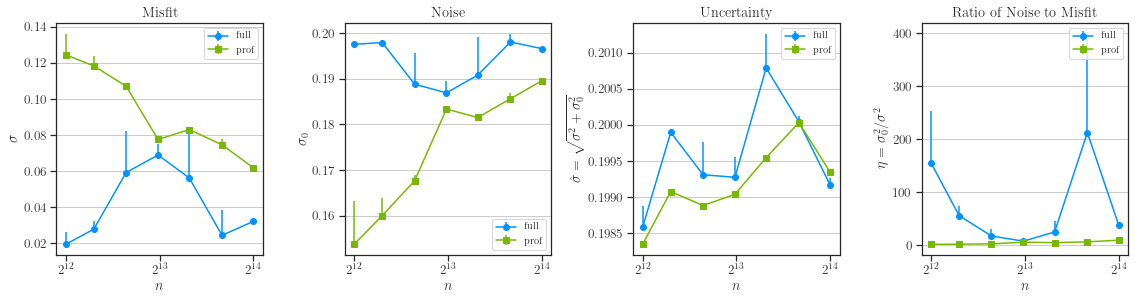

In [9]:
fig, ax = plt.subplots(figsize=(16, 4.4), nrows=1, ncols=4)

# Plot sigmas
plot_var(ax[0], sigma, r'$\sigma$', 'Misfit')
plot_var(ax[1], sigma0, r'$\sigma_0$', 'Noise')
plot_var(ax[2], eq_sigma, r'$\hat{\sigma} = \sqrt{\sigma^2 + \sigma_0^2}$', 'Uncertainty')
plot_var(ax[3], eta, r'$\eta = \sigma_0^2 / \sigma^2$', 'Ratio of Noise to Misfit')

# Save plot
save_plot(plt, 'benchmark_speed_hyperparam')

Plot saved to "benchmark_speed_sparcity.svg".


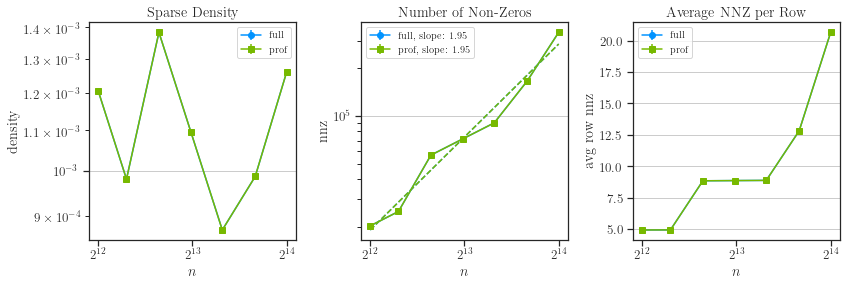

In [10]:
fig, ax = plt.subplots(figsize=(12, 4.2), nrows=1, ncols=3)

# Plot iterations
plot_var(ax[0], density, 'density', 'Sparse Density', ylog=True)
plot_var(ax[1], nnz, 'nnz', 'Number of Non-Zeros', ylog=True, fit=True)
plot_var(ax[2], avg_row_nnz, 'avg row nnz', 'Average NNZ per Row')

# Save plot
save_plot(plt, 'benchmark_speed_sparcity')

Plot saved to "benchmark_speed_posterior.svg".


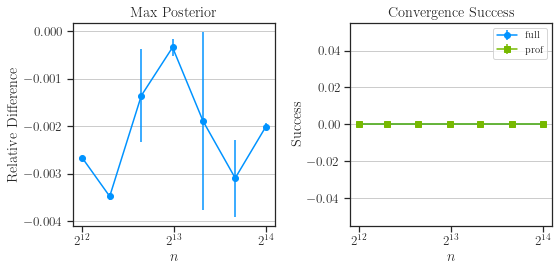

In [11]:
fig, ax = plt.subplots(figsize=(8, 4), nrows=1, ncols=2)

# Plot iterations
plot_var(ax[0], max_fun_rel, 'Relative Difference', 'Max Posterior')
plot_var(ax[1], success, 'Success', 'Convergence Success')

# Save plot
save_plot(plt, 'benchmark_speed_posterior')

In [12]:
#dim = results[0]['full_likelihood'][0]['data']['dimension']
dim = 2
kernel_threshold = results[0]['full_likelihood'][0]['data']['kernel_threshold']
scale = results[0]['full_likelihood'][0]['hyperparam']['scale'][0]
r = -numpy.log(kernel_threshold)
d = r * scale
l = 1.0/(sizes**(1.0/dim) - 1.0)
x = d / l

def circle_lattice_points(radia):
    radia_ = numpy.asarray(radia)
    count = numpy.zeros((radia_.size))
    
    for k in range(radia_.size):
        x = int(numpy.ceil(radia_[k]))
        count[k] = 0
        for i in range(1, x):
            for j in range(1, x):
                if i**2 + j**2 <= radia_[k]**2:
                    count[k] += 1
        count[k] = 4*count[k] + 1 + 4*(x-1)
    if numpy.isscalar(radia):
        return count[0]
    else:
        return count

# Find how many integer points are inside sircle of radius x
#vol = numpy.pi * x**2
#q = vol * sizes
q = circle_lattice_points(x)
print(x)
print(q)

[1.23228725 1.36920805 1.54524909 1.74085024 1.9560115  2.210293
 2.48413461]
[ 5.  5.  9.  9.  9. 13. 21.]


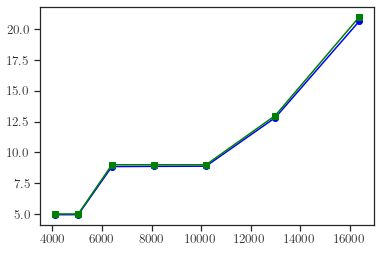

In [13]:
fig, ax = plt.subplots()
ax.plot(sizes, avg_row_nnz['prof'][:, 0], '-o', color='blue')
ax.plot(sizes, q, '-s', color='green')
#ax.set_xscale('log', base=2)